Filtriramo prema uslovima koje nismo mogli da postavimo u "biogrid_download.py" skripti.

In [7]:
import os
import pandas as pd

directory_path = 'files/construction_data/BioGRID'

file_extension = '.txt'

dataframes = []
enterez_id_pairs = set()

for file in os.listdir(directory_path):
    if file.endswith(file_extension):
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path, delimiter='\t')
        df = df[(df['Entrez Gene Interactor A'] != '-') & (df['Entrez Gene Interactor B'] != '-')]
        df = df[df['Experimental System Type'] == 'physical']
        df = df[(df['Official Symbol Interactor A'] != '-') & (df['Official Symbol Interactor B'] != '-')]
        print(len(df))      
        dataframes.append(df)

99685
81277
98144


/tmp/ipykernel_29604/929880889.py:14: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='\t')


In [8]:
print(dataframes[0].columns)

Index(['#BioGRID Interaction ID', 'Entrez Gene Interactor A',
       'Entrez Gene Interactor B', 'BioGRID ID Interactor A',
       'BioGRID ID Interactor B', 'Systematic Name Interactor A',
       'Systematic Name Interactor B', 'Official Symbol Interactor A',
       'Official Symbol Interactor B', 'Synonyms Interactor A',
       'Synonyms Interactor B', 'Experimental System',
       'Experimental System Type', 'Author', 'Pubmed ID',
       'Organism Interactor A', 'Organism Interactor B', 'Throughput', 'Score',
       'Modification', 'Phenotypes', 'Qualifications', 'Tags',
       'Source Database'],
      dtype='object')


Koristimo entrezId pošto zvanična imena često imaju sinonime, koristimo skup da bi ne bi imali duplikate, takodje mapiramo izmedju entrezId i prvog zvaničnog imena na koje naletimo za taj gen (to ime ćemo koristiti).

In [9]:
official_names_mapping = {}
for df in dataframes:
    for index, row in df.iterrows():
        id_a = str(row['Entrez Gene Interactor A'])
        id_b = str(row['Entrez Gene Interactor B'])
        
        if id_a not in official_names_mapping:
            official_names_mapping[id_a] = row['Official Symbol Interactor A']
            
        if id_b not in official_names_mapping:
            official_names_mapping[id_b] = row['Official Symbol Interactor B']
        
        if id_a != id_b:
            pair = tuple(sorted([id_a, id_b]))
            enterez_id_pairs.add(pair)

In [10]:
len(enterez_id_pairs)

192650

Čuvamo mrežu u odgovarajućem formatu.

In [11]:
with open("files/network.sif", "w") as file:
    for pair in enterez_id_pairs:
            first = official_names_mapping[pair[0]]
            second = official_names_mapping[pair[1]]
            
            file.write(f"{first}\t-\t{second}\n")

# Bojenje čvorova

Pravimo skupove prema kojima ćemo da bojimo čvorove.

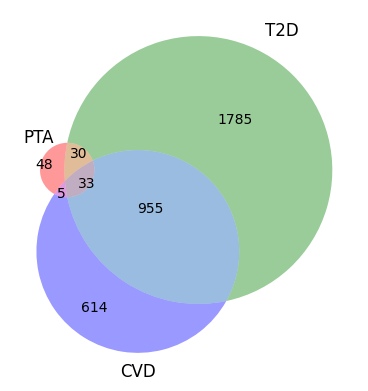

In [6]:
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

file_path = 'files/disease_genes/original_genes.xlsx'
file_names = ['genes_PTA', 'genes_T2D', 'genes_CVD']

df1 = pd.read_excel(file_path, sheet_name=file_names[0])
df2 = pd.read_excel(file_path, sheet_name=file_names[1])
df3 = pd.read_excel(file_path, sheet_name=file_names[2])

genes_PTA = set(df1['Gene'])
genes_T2D = set(df2['Gene'])
genes_CVD = set(df3['Gene'])

intersection_PTA_T2D_not_CVD = (genes_PTA & genes_T2D) - genes_CVD
intersection_PTA_CVD_not_T2D = (genes_PTA & genes_CVD) - genes_T2D
intersection_T2D_CVD_not_PTA = (genes_T2D & genes_CVD) - genes_PTA
intersection_PTA_CVD_T2D = genes_CVD & genes_PTA & genes_T2D

venn3([genes_PTA, genes_T2D, genes_CVD], ('PTA', 'T2D', 'CVD'))

Kod koji boji mrežu odgovarajućom bojom. Pre pocetka izvršavanja ovog koda učitali smo 'files/network.sif' u 'cys_visualizations/output_network.cys'.

In [7]:
import py4cytoscape as p4c


p4c.cytoscape_ping()
# Otvaranje sesije iz datog fajla
p4c.session.open_session('cys_visualizations/output_network.cys')

network_suid = p4c.networks.get_network_suid()

def get_node_color(node):
    if node in intersection_PTA_CVD_T2D:
        return '#A020F0'  
    elif node in intersection_PTA_T2D_not_CVD:
        return '#FFD580'  
    elif node in intersection_T2D_CVD_not_PTA:
        return '#ADD8E6'  
    elif node in intersection_PTA_CVD_not_T2D:
        return '#FF1493'  
    elif node in genes_PTA:
        return '#FF0000'  
    elif node in genes_CVD:
        return '#0000FF'  
    elif node in genes_T2D:
        return '#008000'  
    else:
        return '#CCCCCC'  

# Dohvatamo čvorove
node_table = p4c.tables.get_table_columns('node', columns='name')
node_names = node_table['name'].tolist()  

node_colors = [get_node_color(node) for node in node_names]

try:
    p4c.style_bypasses.set_node_property_bypass(node_names, node_colors, visual_property='NODE_FILL_COLOR')
except Exception as e:
    print(f"Greška prilikom primene boja na čvorove: {e}")
    exit()
## 
cys_file_path = 'output_network_.cys'
try:
    p4c.session.save_session(cys_file_path)
    print(f"Mreža je učitana, čvorovi su obojeni i sačuvani u {cys_file_path}.")
except Exception as e:
    print(f"Greška prilikom čuvanja sesije: {e}")

You are connected to Cytoscape!
Opening /home/korisnik/Desktop/ip2/proteinclustering/cys_visualizations/output_network.cys...
Mreža je učitana, čvorovi su obojeni i sačuvani u output_network_.cys.


In [31]:
from Bio import ExPASy
from Bio import SwissProt

# Funckija koja traži preslikavanje izmedju Entry Name i Gene name, koristi se ukoliko odkomentraišemo kod u funckiji
# ispod, previše sporo radi za preveliki broj preslikavanja.

def search_uniprot(query):
    try:
        handle = ExPASy.get_sprot_raw(query)
        record = SwissProt.read(handle)
        return record
    except ValueError as e:
        print(f"Error: {e}")
        return None

# Učitavamo fajl koji sadrži preslikavanja
entry_name_mapping = pd.read_csv("files/disease_genes/mapping_gene_name_to_entry_name", sep=',')

# Preslikavanje izmedju Entry Name i Gene name i vraća boju čvora, funckioniše prema podacima koje smo preuzeli sa
# https://www.uniprot.org, pokriva većinu preslikavanja.

def map_and_get_node_color(node):
    filtered_rows = entry_name_mapping[entry_name_mapping['Entry Name'] == node]
    
    for index, row in filtered_rows.iterrows():
        gene_name = row['From']
        node_colour = get_node_color(gene_name)
        
        if node_colour != "#CCCCCC":
            return node_colour
        
    return "#CCCCCC"
     
    # Dodatna pretraga preko interneta ukoliko gore ne pronadjemo preslikavanje, potrebno dosta vremena po upitu
    
    #record = search_uniprot(node)

    #if record:
    #    gene_name = search_uniprot(node).gene_name[0]['Name'].split(" ")[0]
    #    entry_name_mapping[node] = gene_name
    #    get_node_color(gene_name)
    #else:
    #    return "#CCCCCC"

Sada bojimo sve klastere, potrebno otvoriti "sesiju" u kojoj su već učitane mreže.

In [36]:
# Za otovorenu sesiju dohvata spisak svih mreža
network_list = p4c.networks.get_network_list()

# Iteriraj kroz svaku mrežu i oboji čvorove
for network_name in network_list:
    try:
        print(network_name)
        p4c.networks.set_current_network(network_name)
        
        node_table = p4c.tables.get_table_columns('node', columns='name')
        node_names = node_table['name'].tolist()
        
        # Odredjivanje boje
        node_colors = [map_and_get_node_color(node) for node in node_names]
        
        # Postavljanje izgleda čvora
        try:
            p4c.style_bypasses.set_node_property_bypass(node_names, node_colors, visual_property='NODE_FILL_COLOR')
            p4c.style_bypasses.set_node_property_bypass(node_names, 35, visual_property='NODE_WIDTH')
            p4c.style_bypasses.set_node_property_bypass(node_names, 35, visual_property='NODE_HEIGHT')
            p4c.style_bypasses.set_node_property_bypass(node_names, 'ELLIPSE', visual_property='NODE_SHAPE')
            
        except Exception as e:
            print(f"Greška prilikom primene boja na čvorove u mreži {network_name}: {e}")
            continue

    except Exception as e:
        print(f"Greška prilikom obrade mreže {network_name}: {e}")

# Sačuvaj sesiju
cys_file_path = 'combined_networks_colored_.cys'
try:
    p4c.session.save_session(cys_file_path)
    print(f"Sve mreže su obojene i sačuvane u {cys_file_path}.")
except Exception as e:
    print(f"Greška prilikom čuvanja sesije: {e}")

module_4.1.sif
module_13.1.sif
module_15.sif
module_7.4.sif
module_6.sif
module_3.sif
module_14.sif
module_13.sif
module_2.sif
module_4.sif
module_11.sif
module_8.2.sif
module_7.2.sif
module_12.sif
module_5.sif
module_9.sif
module_11.1.sif
module_8.1.sif
module_10.sif
module_1.sif
module_7.1.sif
module_2.1.sif
module_9.1.sif
module_8.sif
module_7.3.sif
module_7.sif
Sve mreže su obojene i sačuvane u combined_networks_colored_.cys.
